# Supplementary Methods
**Logistic and Pixel-Based Poisson Models for Species Distribution**

Overview for Report 1 at STATS 9697 001, Western University, London, ON, Canada

By Jorge Lizarazo

To evaluate whether presence–absence modelling and pixel-based count modelling produce consistent spatial patterns, we fitted two generalized linear models (GLMs) using identical environmental predictors:

1. A logistic regression model (binomial GLM) using point-level presence–absence data.

2. A pixel-based Poisson model approximating a spatial point-process, where counts of presences were aggregated at the raster-cell level.

Both models were projected to continuous surfaces across the study area (Quebec) using aligned environmental rasters.


In [159]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import rasterio
import geopandas as gpd
from pathlib import Path

## Logistic GLM (Presence–Absence Model)

### Data

The logistic model was fitted using individual records with binary response:

\[
Y_i \in \{0,1\}
\]

where:
- \(Y_i = 1\) indicates presence,
- \(Y_i = 0\) indicates absence.

Predictors included 20 environmental variables:

\[
X = (x_{1}, x_{2}, \dots, x_{20})
\]

Rows with missing predictor values were removed prior to model fitting.

In [73]:
data_model = pd.read_csv("data/model_dataset.csv")

print(data_model.shape)
print(data_model['presencia'].value_counts())

(887962, 24)
presencia
1    847962
0     40000
Name: count, dtype: int64


In [74]:
#data_model.isna().sum().sort_values(ascending=False)

In [75]:
#np.isinf(data_model[variables]).sum()

In [76]:
#mask_bad = (
#    data_model[variables].isna().any(axis=1) |
#    np.isinf(data_model[variables]).any(axis=1)
#)

#mask_bad.sum()

In [77]:
#data_model.loc[mask_bad, variables].head()

### Model formulation

\[
\text{logit}(p_i) = \log\left(\frac{p_i}{1 - p_i}\right)
= \beta_0 + \sum_{k=1}^{K} \beta_k x_{ik}
\]

where:
- \(p_i = \Pr(Y_i = 1)\)
- \(\beta_0\) is the intercept
- \(\beta_k\) are regression coefficients

Predicted probabilities are obtained as:

\[
\hat{p}(x) = \frac{1}{1 + \exp(-\eta(x))}
\]

where \(\eta(x)\) is the linear predictor.


In [78]:
variables = [
'clay','sand','bio1','bio2','bio3','bio8','bio9','bio10',
'bio11','bio12','bio14','bio15','bio18','bio20','bio23','bio24',
'bio27','bio30','bio31','bio34'
]

In [79]:
data_model = data_model.dropna(subset=variables).copy()

In [80]:

X = data_model[variables]
y = data_model['presencia']

X = sm.add_constant(X)

### Spatial Projection

Environmental rasters were aligned and flattened into a pixel-level dataframe. Missing raster values were replaced by column means **only for prediction purposes**, ensuring complete spatial coverage.

Predicted probabilities were computed for each pixel and reshaped to produce a continuous probability surface.

## Pixel-Based Poisson GLM (Count Model / Point-Process Approximation)

### Pixel Aggregation

Presence points were spatially assigned to raster cells using the raster transform. For each pixel \(j\), the response variable was defined as:

\[
Y_j = \text{number of presence points falling in pixel } j
\]

This produced a count surface where most pixels have zero counts.


In [103]:
raster_dir = Path("recortados_alineados")
rasters = {}

for v in variables:
    rasters[v] = rasterio.open(raster_dir / f"{v}.tif")

In [104]:
template = rasters[variables[0]]
rows, cols = template.shape

pixel_data = {}

for v in variables:
    src = rasters[v]
    arr = src.read(1).astype("float32")

    nodata = src.nodata
    if nodata is not None:
        arr[np.isclose(arr, nodata)] = np.nan

    # catch extreme placeholder values
    arr[arr > 1e10] = np.nan
    arr[arr < -1e10] = np.nan

    pixel_data[v] = arr.flatten()

pixel_df = pd.DataFrame(pixel_data)

### build pixel index grid

In [105]:
transform = template.transform

pixel_df["row"] = np.repeat(np.arange(rows), cols)
pixel_df["col"] = np.tile(np.arange(cols), rows)
pixel_df["count"] = 0

In [106]:
#print(data_model.columns)

### Modeling Domain

To define a valid ecological domain, only pixels with non-missing values in core predictors (clay and sand) were retained:

\[
\mathcal{D} = \{ j : x_{j,\text{clay}} \neq NA \ \text{and} \ x_{j,\text{sand}} \neq NA \}
\]

Pixels outside this domain were excluded from model fitting.


In [107]:
pixel_df["row"]
pixel_df["col"]
pixel_df["count"] = 0

In [108]:
from rasterio.transform import rowcol

In [109]:
presence_points = data_model[data_model["presencia"] == 1]

rows_idx, cols_idx = rowcol(
    transform,
    presence_points["longitude"].values,
    presence_points["latitude"].values
)

valid = (
    (rows_idx >= 0) & (rows_idx < rows) &
    (cols_idx >= 0) & (cols_idx < cols)
)

flat_idx = rows_idx[valid] * cols + cols_idx[valid]
counts = np.bincount(flat_idx, minlength=rows * cols)

pixel_df["count"] = counts

In [110]:
#Sanity check
print("Pixel counts sum:", pixel_df["count"].sum())
print("Presence points:", presence_points.shape[0])

Pixel counts sum: 847962
Presence points: 847962


every presence point was assigned to a pixel

In [111]:
pixel_df.to_csv("data/pixel_poisson_dataset.csv", index=False)
pixel_df.to_pickle("data/pixel_poisson_dataset.pkl")
#pixel_df = pd.read_csv("data/pixel_poisson_dataset.csv")
#pixel_df = pd.read_pickle("data/pixel_poisson_dataset.pkl")

### Model formulation

A Poisson GLM with log link was fitted:

\[
Y_j \sim \text{Poisson}(\lambda_j)
\]

\[
\log(\lambda_j) = \alpha_0 + \sum_{k=1}^{K} \alpha_k x_{jk}^*
\]

where:
- \(\lambda_j\) represents the expected intensity of occurrences per pixel.

This formulation approximates a log-linear spatial point-process model when pixel size is sufficiently small.


In [152]:
log_model = sm.GLM(
    y,
    X,
    family=sm.families.Binomial()
).fit()

print(log_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              presencia   No. Observations:               887831
Model:                            GLM   Df Residuals:                   887810
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15758.
Date:                Wed, 11 Feb 2026   Deviance:                       31515.
Time:                        20:57:25   Pearson chi2:                 9.09e+07
No. Iterations:                    13   Pseudo R-squ. (CS):             0.2818
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.3325      4.708      6.443      0.0

In [153]:
import matplotlib.pyplot as plt

In [154]:
Xp_log = pixel_df[variables].copy()

Xp_log = Xp_log.replace([np.inf, -np.inf], np.nan)
Xp_log = Xp_log.fillna(Xp_log.mean())   # SOLO para mapear

Xp_log = sm.add_constant(Xp_log)

pixel_df["prob"] = log_model.predict(Xp_log)

prob_surface = pixel_df["prob"].values.reshape(rows, cols)

## Pixel Poisson GLM

In [113]:
Xp = pixel_df[variables].copy()
yp = pixel_df["count"]

Xp = Xp.replace([np.inf, -np.inf], np.nan)

# define modeling domain using core layers
core_vars = ["clay", "sand"]
domain_mask = pixel_df[core_vars].notna().all(axis=1)

Xp = Xp.loc[domain_mask]
yp = yp.loc[domain_mask]

# fill remaining missing predictor values
Xp = Xp.fillna(Xp.mean())

# removing zero-variance columns
stds = Xp.std()
Xp = Xp[stds[stds > 0].index]

# standardize
Xp = (Xp - Xp.mean()) / Xp.std()
Xp = sm.add_constant(Xp)

In [114]:


pois_model = sm.GLM(
    yp,
    Xp,
    family=sm.families.Poisson()
).fit()

print(pois_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  count   No. Observations:                 1412
Model:                            GLM   Df Residuals:                     1391
Model Family:                 Poisson   Df Model:                           20
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.1763e+05
Date:                Wed, 11 Feb 2026   Deviance:                   1.0335e+06
Time:                        20:29:58   Pearson chi2:                 2.04e+06
No. Iterations:                     9   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6251      0.009    186.806      0.0

### Standardization

Predictors were standardized:

\[
x_{jk}^* = \frac{x_{jk} - \bar{x}_k}{s_k}
\]

Zero-variance predictors were removed prior to fitting.


In [115]:
print(pixel_df.shape)
print(Xp.shape)
print(pois_model.nobs)

(2365, 23)
(1412, 21)
1412


In [116]:
#na_fraction = pixel_df[variables].isna().mean().sort_values(ascending=False)
#print(na_fraction.head(10))

In [117]:
print(rows, cols)
print(rows * cols)

43 55
2365


In [118]:
#raster_dir = Path("recortados_alineados")

#for v in ["clay", "bio1"]:
#    with rasterio.open(raster_dir / f"{v}.tif") as src:
#        print("\n---", v, "---")
#        print("shape:", src.shape)
#        print("resolution:", src.res)
#        print("bounds:", src.bounds)
#        print("crs:", src.crs)
#        print("nodata:", src.nodata)

## Processing


In [119]:
coef_compare = pd.DataFrame({
    "logistic": log_model.params,
    "poisson": pois_model.params
})

In [120]:
print(coef_compare.corr())

          logistic   poisson
logistic  1.000000  0.193415
poisson   0.193415  1.000000


<Axes: xlabel='logistic', ylabel='poisson'>

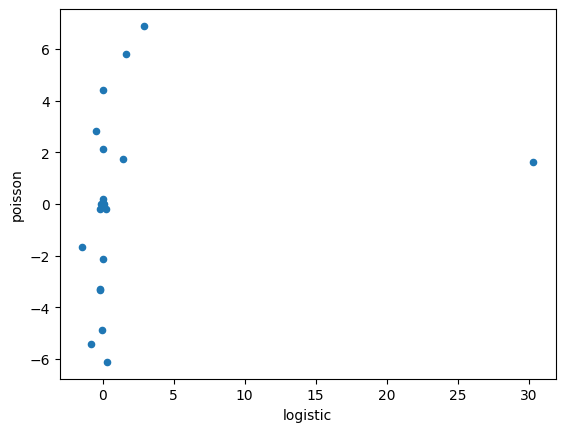

In [121]:
coef_compare.plot.scatter(x="logistic", y="poisson")

In [155]:
Xp_pred = pixel_df[variables].copy()
Xp_pred = Xp_pred.loc[domain_mask]
Xp_pred = Xp_pred.fillna(Xp_pred.mean())
Xp_pred = Xp_pred[stds[stds > 0].index]
Xp_pred = (Xp_pred - Xp_pred.mean()) / Xp_pred.std()
Xp_pred = sm.add_constant(Xp_pred)

pixel_df.loc[domain_mask, "lambda"] = pois_model.predict(Xp_pred)

intensity = np.full(rows * cols, np.nan)
intensity[domain_mask.values] = pixel_df.loc[domain_mask, "lambda"]

intensity = intensity.reshape(rows, cols)

In [156]:
extent = [
    template.bounds.left,
    template.bounds.right,
    template.bounds.bottom,
    template.bounds.top
]

In [167]:

quebec = gpd.read_file("Politic_divition/Total_quebec.shp")
quebec.crs = "EPSG:4326"

In [168]:
print(quebec.crs)
print(quebec.total_bounds)

EPSG:4326
[-79.76532427  44.99135833 -56.93492689  62.5824657 ]


In [169]:
from rasterio.features import geometry_mask

mask = geometry_mask(
    quebec.geometry,
    transform=template.transform,
    invert=True,
    out_shape=(rows, cols)
)

In [170]:
prob_surface[~mask] = np.nan
intensity[~mask] = np.nan

In [171]:
extent = [
    template.bounds.left,
    template.bounds.right,
    template.bounds.bottom,
    template.bounds.top
]


In [174]:
intensity_masked = intensity.copy()
intensity_masked[~mask] = np.nan

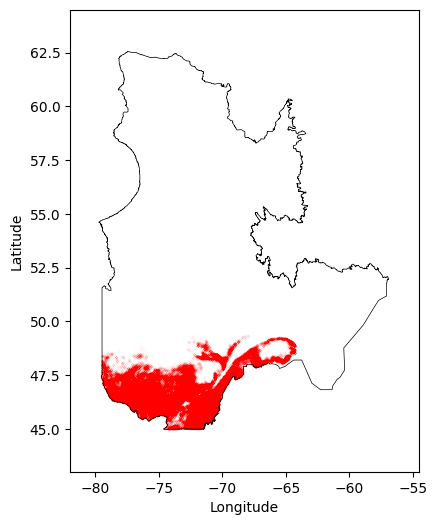

In [200]:
fig, ax = plt.subplots(figsize=(7,6))

# shapefile de Quebec
quebec.plot(
    ax=ax,
    facecolor="white",
    edgecolor="black",
    linewidth=0.5
)

# puntos de presencia
ax.scatter(
    presence_points["longitude"],
    presence_points["latitude"],
    s=0.01,
    c="red",
    alpha=0.04
)

# MISMA EXTENSION QUE EL RASTER
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

ax.set_title("")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

### Intensity Surface

Predicted intensity was computed as:

\[
\hat{\lambda}(x) = \exp\left(\hat{\alpha}_0 + \sum_{k=1}^{K} \hat{\alpha}_k x_k^*\right)
\]

The resulting values represent relative occurrence intensity per raster cell.

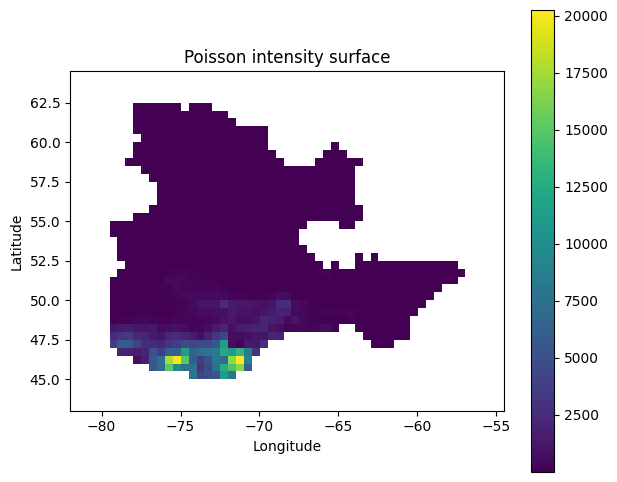

In [202]:
plt.figure(figsize=(7,6))
plt.imshow(intensity_masked, extent=extent, origin="upper")
plt.title("Poisson intensity surface")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

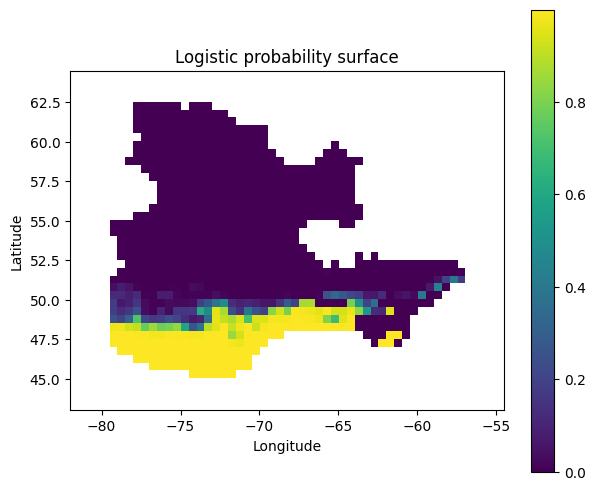

In [176]:
prob_masked = prob_surface.copy()
prob_masked[~mask] = np.nan

plt.figure(figsize=(7,6))
plt.imshow(prob_masked, extent=extent, origin="upper")
plt.title("Logistic probability surface")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()
plt.show()

## Model Comparison

### Coefficient Comparison

Regression coefficients from both models were compared using:

- Pearson correlation between parameter vectors
- Scatterplots of \(\beta_k\) (logistic) vs \(\alpha_k\) (Poisson)

Intercepts were excluded when evaluating ecological consistency.

---

### Surface Correlation

To assess spatial agreement, we computed:

\[
\rho = \text{cor}\left(\hat{p}(x), \frac{\hat{\lambda}(x)}{\max(\hat{\lambda}(x))}\right)
\]

after restricting to valid pixels.

This evaluates whether the two modeling frameworks recover similar spatial gradients.


In [128]:
print("Logistic AIC:", log_model.aic)
print("Poisson AIC:", pois_model.aic)

Logistic AIC: 31557.2612448714
Poisson AIC: 1035299.4313880575


## Interpretation

The logistic model estimates:

\[
\Pr(\text{presence} \mid x)
\]

The Poisson model estimates:

\[
\text{relative intensity of occurrences per pixel}
\]

Under certain sampling assumptions (e.g., rare events and large background domain), presence–absence logistic regression and Poisson point-process models are theoretically related. The comparison performed here evaluates empirical consistency between the two approaches given the same environmental predictors.

---

## Information Criteria

Model fit was evaluated using Akaike Information Criterion (AIC):

\[
\text{AIC} = -2\ell + 2K
\]

where:
- \(\ell\) is the log-likelihood
- \(K\) is the number of parameters

AIC values are reported separately for the logistic and Poisson models.

In [129]:
coef_compare.corr()

,logistic,poisson
logistic,1.000000,0.193415
poisson,0.193415,1.000000


<Axes: xlabel='logistic', ylabel='poisson'>

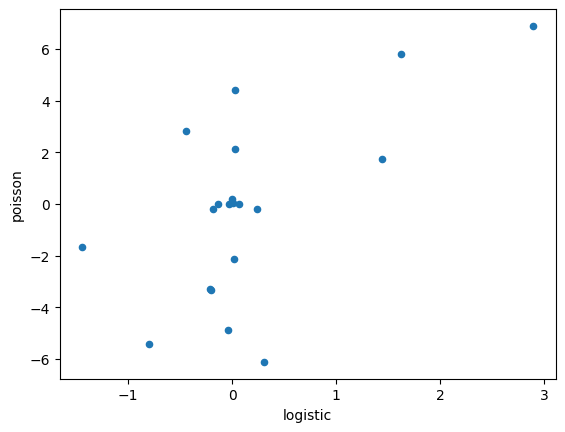

In [205]:
coef_compare_no_intercept = coef_compare.drop("const")

coef_compare_no_intercept.plot.scatter(
    x="logistic",
    y="poisson"
)

In [204]:
mask_valid = (~np.isnan(prob_surface)) & (~np.isnan(intensity))

np.corrcoef(
    prob_surface[mask_valid],
    intensity[mask_valid]
)

array([[1.        , 0.61668512],
       [0.61668512, 1.        ]])

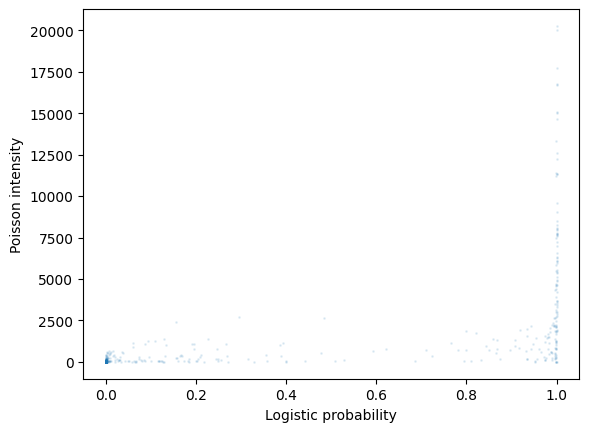

In [206]:
plt.scatter(
    prob_surface[mask_valid],
    intensity[mask_valid],
    s=1,
    alpha=0.1
)
plt.xlabel("Logistic probability")
plt.ylabel("Poisson intensity")
plt.show()

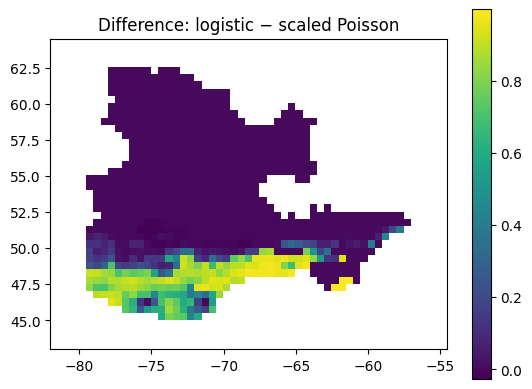

In [207]:
diff = prob_surface - (
    intensity / np.nanmax(intensity)
)

plt.imshow(diff, extent=extent, origin="upper")
plt.title("Difference: logistic − scaled Poisson")
plt.colorbar()
plt.show()